# Santander Meteorology Group notebooks

***

> This Work has been submitted to BAMS (Bulletin of the American Meteorological Society). Copyright in this Work may be transferred without further notice.

> This notebook reproduces figures 5 and 6 available in the article "The worldwide C3S CORDEX grand ensemble: A major contribution to assess regional climate change in the IPCC AR6 Atlas". 
>

# Assessing the consistency of the worldwide C3S CORDEX grand ensemble in overlapping regions

18/05/2022

J. Diez-Sierra (Santander Meteorology Group, Instituto de Física de Cantabria (IFCA), CSIC - Universidad de Cantabria, Santander, Spain)

This script works with the dataset aggregated regionally available on the AR6 IPCC-WG1 GitHub repository (Iturbide et al., 2021) for CMIP5 and CORDEX projects (https://github.com/IPCC-WG1/Atlas/tree/main/datasets-aggregated-regionally/data/). This dataset contains monthly means of temperature and precipitation spatially averaged over the new subcontinental climatic regions used in the IPCC AR6-WG1. Note that the dataset used here comprises a subset of the CORDEX grand ensemble available at the C3S-CDS, therefore the results are slightly different from those available in the article. Further, in the article we considered only those simulations that overlap more than 90% of the grid cells with the regions analyzed, while here the selection criteria is different (~80%, see the documentations available on the AR6 IPCC-WG1 GitHub: https://github.com/IPCC-WG1/Atlas/tree/main/datasets-aggregated-regionally).

# Loading packages

This script requires regionmask version 0.6.1 or later and xarray version 0.15.1 or later. Check the documentation of regionmask for details.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import warnings

In [2]:
import regionmask
import xarray as xr

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

# Load the reference regions

The regions are available at regionmask.defined_regions.ar6. The whole set of 58 regions is available under (ar6.all). In addition the land (ar6.land) and ocean (ar6.ocean) regions are given separately. The numbering is kept consistent between the categories. Note that some regions are in the land and in the ocean categories (e.g. the Mediterranean).

In [6]:
ar6_all = regionmask.defined_regions.ar6.all
ar6_all

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

# Defining some functions which will be used later 

In [7]:
def traverseDir(root):
    """Function to show all csv files unde a folder """
    for (dirpath, dirnames, filenames) in os.walk(root):
        for file in filenames:
            if file.endswith('.csv'):
                yield os.path.join(dirpath, file)

In [8]:
def select_period_SW(x, y, period_hist, period_fut, summer, winter):
    """Function to select data for different seasons"""
    #select years 
    x_period = x.loc[np.in1d(x.index.year, period_hist)]
    y_period = y.loc[np.in1d(y.index.year, period_fut)]
    # select summer 
    x_period_s = x_period.loc[np.in1d(x_period.index.month, summer)]
    y_period_s = y_period.loc[np.in1d(y_period.index.month, summer)]
    # select winter
    x_period_w = x_period.loc[np.in1d(x_period.index.month, winter)]
    y_period_w = y_period.loc[np.in1d(y_period.index.month, winter)]
    return x_period, y_period, x_period_s, y_period_s, x_period_w, y_period_w

In [9]:
def select_sim_CORDEX(file_last, dom, var, mask):
    """Select CORDEX simulations for a specific: domain, variable and mask"""
    file_dom = [file for file in file_last if 'CORDEX-' + dom + '_' in file]
    file_dom_sce = [file for file in file_dom if '_' + var + '_'  in file]
    file_dom_sce = [file for file in file_dom_sce if '_' + mask + '/'  in file]
    file_dom_sce_res = []
    for file in file_dom_sce:
        if dom + '-' + '44' in file:
            file_22 = file.replace(dom + '-' + '44', dom + '-' + '22')
            if not file_22 in file_dom_sce:
                file_dom_sce_res.append(file)
            else:
                a = 1
        else:
            file_dom_sce_res.append(file)        
    return file_dom_sce_res

In [10]:
def select_sim_CMIP5(file_last, var, mask):
    """Select CMIP5 simulations for a specific: domain, variable and mask"""
    file_dom_sce = [file for file in file_last if 'CMIP5_' + var + '_'  in file]
    file_dom_sce = [file for file in file_dom_sce if '_' + mask + '/'  in file]
    file_dom_sce_res = []
    for file in file_dom_sce:
        file_dom_sce_res.append(file)        
    return file_dom_sce_res

In [11]:
def calculate_delta(select_sim_90, reg, period_hist, period_fut, experiment, variable):
    """Calculate deltas (climate signals) for temperature and precipitation"""
    res_res = pd.DataFrame(index = select_sim_90, columns = ['period', 'summer', 'winter'])
    for file in select_sim_90:
        if experiment == 'CORDEX':
            raw_exp = pd.read_csv(file, index_col = 0, parse_dates = True, comment='#')
        elif experiment == 'CMIP5':
            raw_exp = pd.read_csv(file, index_col = 0, parse_dates = True, nrows = 100*12, comment='#')
        try:
            hist_exp = pd.read_csv(file.replace('rcp85', 'historical'), index_col = 0, parse_dates = True, comment='#')
        except:
            print("Historical simulation not available for simulation:" + file)
            continue
        
        if reg in hist_exp.columns:
            if variable == 'pr':
                hist_p, raw_p, hist_s, raw_s, hist_w, raw_w = \
                    select_period_SW(hist_exp, raw_exp, period_hist, period_fut, summer, winter)             
            elif variable == 'tas':
                hist_p, raw_p, hist_s, raw_s, hist_w, raw_w = \
                    select_period_SW(hist_exp, raw_exp, period_hist, period_fut, summer, winter)

            if variable == 'pr':
                res_res.loc[file]['period'] = (raw_p[reg].mean()-hist_p[reg].mean())/hist_p[reg].mean()
                res_res.loc[file]['summer'] = (raw_s[reg].mean()-hist_s[reg].mean())/hist_p[reg].mean()
                res_res.loc[file]['winter'] = (raw_w[reg].mean()-hist_w[reg].mean())/hist_p[reg].mean()
            elif variable == 'tas':
                res_res.loc[file]['period'] = raw_p[reg].mean()-hist_p[reg].mean()
                res_res.loc[file]['summer'] = raw_s[reg].mean()-hist_s[reg].mean()
                res_res.loc[file]['winter'] = raw_w[reg].mean()-hist_w[reg].mean()

    return res_res.dropna()

In [12]:
def select_regions_overlap(tas_mean_dom_AR6_period, tas_mean_dom_AR6_n_sim):
    """Selecting regions with 2 or more overlapping CORDEX domains"""
    tas_mean_dom_AR6_period_drop = tas_mean_dom_AR6_period.dropna(axis=0, how = 'all')
    tas_mean_dom_AR6_period_drop = tas_mean_dom_AR6_period_drop.dropna(axis=1, how = 'all')
    tas_mean_dom_AR6_period_drop = tas_mean_dom_AR6_period_drop.dropna(axis=1, thresh = 2)

    tas_mean_dom_AR6_n_sim_drop = tas_mean_dom_AR6_n_sim.copy()
    tas_mean_dom_AR6_n_sim_drop[tas_mean_dom_AR6_n_sim_drop == 0] = np.nan
    tas_mean_dom_AR6_n_sim_drop = tas_mean_dom_AR6_n_sim_drop.dropna(axis=0, how = 'all')
    tas_mean_dom_AR6_n_sim_drop = tas_mean_dom_AR6_n_sim_drop.dropna(axis=1, how = 'all')
    tas_mean_dom_AR6_n_sim_drop = tas_mean_dom_AR6_n_sim_drop.dropna(axis=1, thresh = 2)

    tas_mean_CORDEX = np.mean(tas_mean_dom_AR6_period*tas_mean_dom_AR6_n_sim/tas_mean_dom_AR6_n_sim.mean(axis=0), axis = 0)
    tas_mean_CORDEX_drop = tas_mean_CORDEX.loc[tas_mean_dom_AR6_n_sim_drop.columns] 
    
    return tas_mean_CORDEX, tas_mean_CORDEX_drop, tas_mean_dom_AR6_period_drop, tas_mean_dom_AR6_n_sim_drop

In [13]:
def calculate_delta_CMIP5_subensemble(select_sim_90, reg, period_hist, period_fut, files_CMIP5_rcp85, variable):
    """Calculate delta CMIP5 subensemble (see Boé et al. 2020)"""
    res_res = pd.DataFrame(index = select_sim_90, columns = ['period', 'summer', 'winter'])
    for file in select_sim_90:
        GCM = file.split('/')[-1].split('_')[0]; run = file.split('/')[-1].split('_')[1]
        file_sel = []
        for fff in files_CMIP5_rcp85:
            if (fff.split('/')[-1].split('_')[1] in GCM) and (run in fff):
                file_sel.append(fff)
        
        if len(file_sel) == 0:
    
            print("CMIP5 model not available " + reg + ' : ' + GCM  + '_' + run) 
            res_res.loc[file]['period'] = np.nan; res_res.loc[file]['summer'] = np.nan; res_res.loc[file]['winter'] = np.nan
            
        else:
        
            raw_exp = pd.read_csv(file_sel[0], index_col = 0, parse_dates = True, nrows = 100*12, comment='#')
            hist_exp = pd.read_csv(file_sel[0].replace('rcp85', 'historical'), index_col = 0, parse_dates = True, comment='#')
            
            if variable == 'pr':
                hist_p, raw_p, hist_s, raw_s, hist_w, raw_w = \
                    select_period_SW(hist_exp, raw_exp, period_hist, period_fut, summer, winter)
                res_res.loc[file]['period'] = (raw_p[reg].mean()-hist_p[reg].mean())/hist_p[reg].mean()
                res_res.loc[file]['summer'] = (raw_s[reg].mean()-hist_s[reg].mean())/hist_p[reg].mean()
                res_res.loc[file]['winter'] = (raw_w[reg].mean()-hist_w[reg].mean())/hist_p[reg].mean()
                            
            elif variable == 'tas':
                hist_p, raw_p, hist_s, raw_s, hist_w, raw_w = \
                    select_period_SW(hist_exp, raw_exp, period_hist, period_fut, summer, winter)
                res_res.loc[file]['period'] = raw_p[reg].mean()-hist_p[reg].mean()
                res_res.loc[file]['summer'] = raw_s[reg].mean()-hist_s[reg].mean()
                res_res.loc[file]['winter'] = raw_w[reg].mean()-hist_w[reg].mean()
        
    return res_res

# Defining input parameters 

In [14]:
domains = ['EUR', 'NAM', 'CAM', 'SAM', 'ARC', 'AFR', 'SEA', 'EAS', 'WAS', 'ANT', 'AUS']
scenarios = ['historical', 'rcp85']
period_hist = np.arange(1986,2006)
period_fut = np.arange(2080,2100)
mask = 'landsea'
variables = ['pr', 'tas']
summer = np.array([6,7,8])
winter = np.array([12,1,2])

In [15]:
#Here we use the data available at: https://github.com/IPCC-WG1/Atlas/tree/main/datasets-aggregated-regionally/data/
path_IPCC_WG1 = ".../Atlas/datasets-aggregated-regionally/data/"
path_CORDEX = path_IPCC_WG1 + 'CORDEX/'
path_CMIP5 = path_IPCC_WG1 + 'CMIP5/'

## CORDEX

In [16]:
## select CORDEX files from the Atlas
files_CORDEX = list(traverseDir(path_CORDEX))
files_CORDEX_rcp85 = [file for file in files_CORDEX if 'rcp85' in file]
files_CORDEX_historical = [file for file in files_CORDEX if 'historical' in file]

In [17]:
## define dataframes to save the results
pr_mean_dom_AR6_period = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)
pr_mean_dom_AR6_n_sim = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)

tas_mean_dom_AR6_period = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)
tas_mean_dom_AR6_n_sim = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)

### Calculate CORDEX mosaic ensembles

In [18]:
%%capture
# CORDEX: calculate delta changes for pr and tas
tas_dic = {}; pr_dic = {}
for dom in domains:
    for variable in variables:
        f_CORDEX = select_sim_CORDEX(files_CORDEX_rcp85, dom, variable, mask)
        for reg in ar6_all.abbrevs:

            if variable == 'tas':
                res_del = calculate_delta(f_CORDEX, reg, period_hist, period_fut, 'CORDEX', variable)
                if not len(res_del)==0:
                    tas_dic[dom + '_' + reg] = res_del
                    tas_mean_dom_AR6_n_sim.loc[dom][reg] = np.sum(~pd.isnull(res_del['period'].values))
                    tas_mean_dom_AR6_period.loc[dom][reg] = res_del['period'].mean()

            elif variable == 'pr':
                res_del = calculate_delta(f_CORDEX, reg, period_hist, period_fut, 'CORDEX', variable)
                if not len(res_del)==0:
                    pr_dic[dom + '_' + reg] = res_del
                    pr_mean_dom_AR6_n_sim.loc[dom][reg] = np.sum(~pd.isnull(res_del['period'].values))
                    pr_mean_dom_AR6_period.loc[dom][reg] = res_del['period'].mean()

### Calculate CORDEX grand ensemble

In [19]:
## Calculate Grand Ensemble weighting with equal values those simulations with equal GCM_r_RCM_v for different domains

##pr
grand_ensemble_pr = pd.DataFrame(index = ar6_all.abbrevs, columns = ['Grand_ensemble'])
for reg in ar6_all.abbrevs:
    aux_reg = []
    n = 0
    for ky in pr_dic.keys():
        if ky.split('_')[1] == reg:
            if n == 0:
                aux_reg = pr_dic[ky]['period']
            else:
                aux_reg = pd.concat([aux_reg, pr_dic[ky]['period']])
            n = n +1
    if not len(aux_reg)==0:
        GCM_r_RCM_v = []
        for sim in aux_reg.index:
            GCM_r_RCM_v.append('_'.join([sim.split('/')[-1].split('_')[0], sim.split('/')[-1].split('_')[1],  
                                    sim.split('/')[-1].split('_')[3], sim.split('/')[-1].split('_')[4]]))
        reg_res = []
        for sim_st in np.unique(GCM_r_RCM_v):
            pos = [ns for ns, sim in enumerate(GCM_r_RCM_v) if sim_st == sim]
            if len(pos) == 1:
                reg_res.append(aux_reg[pos[0]])
            else:
                reg_res.append(np.mean([aux_reg[p] for p in pos]))
        grand_ensemble_pr['Grand_ensemble'].loc[reg] = np.mean(reg_res)

##tas
grand_ensemble_tas = pd.DataFrame(index = ar6_all.abbrevs, columns = ['Grand_ensemble'])
for reg in ar6_all.abbrevs:
    aux_reg = []
    n = 0
    for ky in tas_dic.keys():
        if ky.split('_')[1] == reg:
            if n == 0:
                aux_reg = tas_dic[ky]['period']
            else:
                aux_reg = pd.concat([aux_reg, tas_dic[ky]['period']])
            n = n +1
    if not len(aux_reg)==0:
        GCM_r_RCM_v = []
        for sim in aux_reg.index:
            GCM_r_RCM_v.append('_'.join([sim.split('/')[-1].split('_')[0], sim.split('/')[-1].split('_')[1],  
                                    sim.split('/')[-1].split('_')[3], sim.split('/')[-1].split('_')[4]]))
        reg_res = []
        for sim_st in np.unique(GCM_r_RCM_v):
            pos = [ns for ns, sim in enumerate(GCM_r_RCM_v) if sim_st == sim]
            if len(pos) == 1:
                reg_res.append(aux_reg[pos[0]])
            else:
                reg_res.append(np.mean([aux_reg[p] for p in pos]))
        grand_ensemble_tas['Grand_ensemble'].loc[reg] = np.mean(reg_res)

In [20]:
tas_mean_CORDEX, tas_mean_CORDEX_drop, tas_mean_dom_AR6_period_drop, tas_mean_dom_AR6_n_sim_drop = \
                                    select_regions_overlap(tas_mean_dom_AR6_period, tas_mean_dom_AR6_n_sim)

pr_mean_CORDEX, pr_mean_CORDEX_drop, pr_mean_dom_AR6_period_drop, pr_mean_dom_AR6_n_sim_drop = \
                                    select_regions_overlap(pr_mean_dom_AR6_period, pr_mean_dom_AR6_n_sim)

In [21]:
pr_mean_CORDEX_drop_new = grand_ensemble_pr.loc[pr_mean_CORDEX_drop.index]
tas_mean_CORDEX_drop_new = grand_ensemble_tas.loc[pr_mean_CORDEX_drop.index]

## CMIP5

In [22]:
## select CMIP5 files from the Atlas
files_CMIP5 = list(traverseDir(path_CMIP5))
files_CMIP5_rcp85 = [file for file in files_CMIP5 if 'rcp85' in file]
files_CMIP5_historical = [file for file in files_CMIP5 if 'historical' in file]

In [23]:
pr_mean_dom_AR6_CMIP5 = pd.DataFrame(index = ['period', 'n_sim'], columns = ar6_all.abbrevs)
tas_mean_dom_AR6_CMIP5 = pd.DataFrame(index = ['period', 'n_sim'], columns = ar6_all.abbrevs)

In [24]:
# CMIP5: calculate delta changes for pr and tas
tas_dic_CMIP5 = {}; pr_dic_CMIP5 = {}
for variable in variables:
    f_CMIP5 = select_sim_CMIP5(files_CMIP5_rcp85, variable, mask)
    for reg in ar6_all.abbrevs:
        if variable == 'tas':
            res_del = calculate_delta(f_CMIP5, reg, period_hist, period_fut, 'CMIP5', variable)
            if not len(res_del)==0:
                tas_dic_CMIP5[reg] = res_del
                tas_mean_dom_AR6_CMIP5.loc['n_sim'][reg] = len(f_CMIP5)
                tas_mean_dom_AR6_CMIP5.loc['period'][reg] = res_del['period'].mean()

        elif variable == 'pr':
            res_del = calculate_delta(f_CMIP5, reg, period_hist, period_fut, 'CMIP5', variable)
            if not len(res_del)==0:
                pr_dic_CMIP5[reg] = res_del
                pr_mean_dom_AR6_CMIP5.loc['n_sim'][reg] = len(f_CMIP5)
                pr_mean_dom_AR6_CMIP5.loc['period'][reg] = res_del['period'].mean()

In [25]:
tas_mean_dom_AR6_CMIP5 =  tas_mean_dom_AR6_CMIP5[tas_mean_dom_AR6_period_drop.columns]
pr_mean_dom_AR6_CMIP5 =  pr_mean_dom_AR6_CMIP5[pr_mean_dom_AR6_period_drop.columns]

### Calculate subensemble CMIP5

In [26]:
pr_mean_dom_AR6_period_CMIP5 = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)
tas_mean_dom_AR6_period_CMIP5 = pd.DataFrame(index = domains, columns = ar6_all.abbrevs)

In [27]:
%%capture
##sub ensemble CMIP5
# CMIP5 - CORDEX
tas_dic_CMIP5_sub = {}; pr_dic_CMIP5_sub = {}
for dom in domains:
    for variable in variables:
        f_CORDEX = select_sim_CORDEX(files_CORDEX_rcp85, dom, variable, mask)
        for reg in ar6_all.abbrevs:
            
            if variable == 'tas':
                files_CMIP5_rcp85_tas = [f for f in files_CMIP5_rcp85 if '_tas_' in f]
                files_CMIP5_rcp85_tas_landsea = [f for f in files_CMIP5_rcp85_tas if '_' + mask +'/' in f]
                res_del = calculate_delta_CMIP5_subensemble(f_CORDEX, reg, period_hist, period_fut,
                                                           files_CMIP5_rcp85_tas_landsea, variable)
                if not len(res_del)==0:
                    tas_dic_CMIP5_sub[dom + '_' + reg] = res_del
                    #tas_mean_dom_AR6_n_sim.loc[dom][reg] = len(select_sim_90)
                    tas_mean_dom_AR6_period_CMIP5.loc[dom][reg] = res_del['period'].mean()

            elif variable == 'pr':
                files_CMIP5_rcp85_pr = [f for f in files_CMIP5_rcp85 if '_pr_' in f]
                files_CMIP5_rcp85_pr_landsea = [f for f in files_CMIP5_rcp85_pr if  '_' + mask  +'/' in f]
                res_del = calculate_delta_CMIP5_subensemble(f_CORDEX, reg, period_hist, period_fut,
                                                           files_CMIP5_rcp85_pr_landsea, variable)
                if not len(res_del)==0:
                    pr_dic_CMIP5_sub[dom + '_' + reg] = res_del
                    #pr_mean_dom_AR6_n_sim.loc[dom][reg] = len(select_sim_90)
                    pr_mean_dom_AR6_period_CMIP5.loc[dom][reg] = res_del['period'].mean()

In [28]:
tas_mean_dom_AR6_period_drop_CMIP5 = tas_mean_dom_AR6_period_CMIP5.dropna(axis=0, how = 'all')
tas_mean_dom_AR6_period_drop_CMIP5 = tas_mean_dom_AR6_period_drop_CMIP5.dropna(axis=1, how = 'all')
tas_mean_dom_AR6_period_drop_CMIP5 = tas_mean_dom_AR6_period_drop_CMIP5.dropna(axis=1, thresh = 2)
tas_mean_CMIP5_CORDEX = np.mean(tas_mean_dom_AR6_period_CMIP5*tas_mean_dom_AR6_n_sim/tas_mean_dom_AR6_n_sim.mean(axis=0), axis = 0)
tas_mean_CMIP5_CORDEX_drop = tas_mean_CMIP5_CORDEX.loc[tas_mean_dom_AR6_n_sim_drop.columns] 

In [29]:
pr_mean_dom_AR6_period_drop_CMIP5 = pr_mean_dom_AR6_period_CMIP5.dropna(axis=0, how = 'all')
pr_mean_dom_AR6_period_drop_CMIP5 = pr_mean_dom_AR6_period_drop_CMIP5.dropna(axis=1, how = 'all')
pr_mean_dom_AR6_period_drop_CMIP5 = pr_mean_dom_AR6_period_drop_CMIP5.dropna(axis=1, thresh = 2)
pr_mean_CMIP5_CORDEX = np.mean(pr_mean_dom_AR6_period_CMIP5*pr_mean_dom_AR6_n_sim/pr_mean_dom_AR6_n_sim.mean(axis=0), axis = 0)
pr_mean_CMIP5_CORDEX_drop = pr_mean_CMIP5_CORDEX.loc[pr_mean_dom_AR6_n_sim_drop.columns] 

## Plotting results

In [30]:
legend_elements = [Patch(facecolor='w', edgecolor='k',label='CMIP5 (ensemble)'),
                   Patch(facecolor='r', edgecolor='r',label='CORDEX (grand ensemble)', alpha = 0.5),
                   Patch(facecolor='g', edgecolor='g',label='CORDEX (mosaic ensemble)', alpha = 0.5),
                   Line2D([0], [0], marker='o', color='k', label='CMIP5 simulation', 
                          markerfacecolor='w', markersize=5, linestyle = 'None'),
                   Line2D([0], [0], marker='o', color='r', label='CORDEX simulation', 
                          markerfacecolor='r', markersize=2, linestyle = 'None')]

### Precipitation

/home/javi/anaconda3/envs/AR6_regions/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


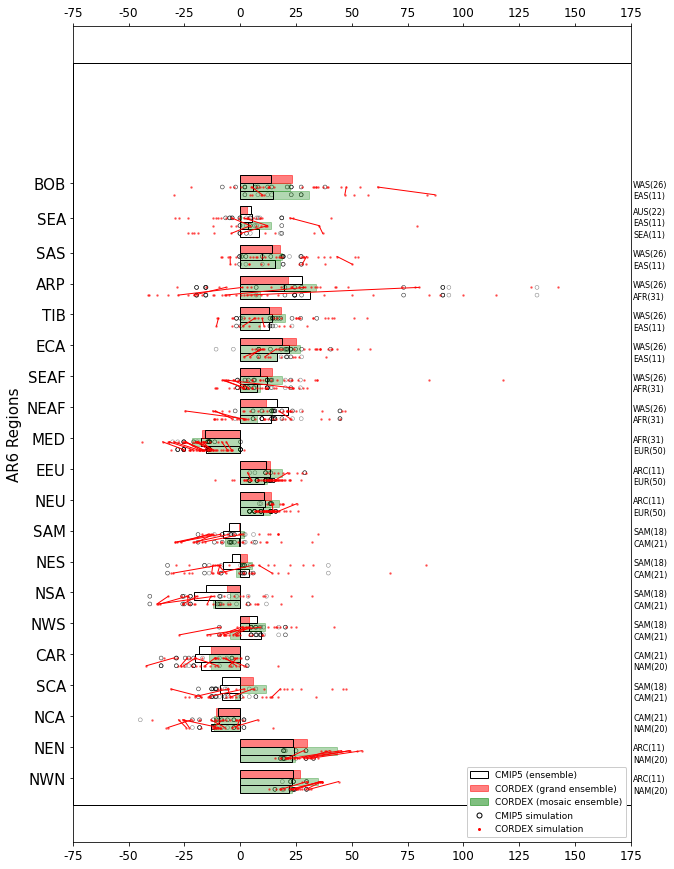

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    fig = plt.figure(figsize = (10, 15))
    ax = fig.add_subplot(111)
    ax.add_patch(Rectangle((-75, 0), 175+75, 19.2, fill=None, alpha=1))
    y_means = []
    doms_string = []
    posi_y = 0.3
    sep_reg = []

    for n_reg, reg in enumerate(pr_mean_dom_AR6_period_drop.columns):

        doms_COR = pr_mean_dom_AR6_period_drop[reg][pr_mean_dom_AR6_period_drop[reg].notnull()].index
        yvals = 100*pr_mean_dom_AR6_period_drop[reg][pr_mean_dom_AR6_period_drop[reg].notnull()]
        yvals_CMIP5 = 100*pr_mean_dom_AR6_period_drop_CMIP5[reg][pr_mean_dom_AR6_period_drop_CMIP5[reg].notnull()]
        nsim_mosaic = pr_mean_dom_AR6_n_sim_drop[reg].values[~pd.isnull(pr_mean_dom_AR6_n_sim_drop[reg].values)]

        if len(yvals) == 2: 
            for xval_n, xval in enumerate(doms_COR):
                if xval_n == 0: sep_reg.append(posi_y)
                ax.add_patch(Rectangle((0, posi_y), yvals[xval_n], 0.2, color = 'green', alpha=0.3))
                ax.add_patch(Rectangle((0, posi_y), yvals_CMIP5[xval_n], 0.2, fill=None, alpha=1))

                delta_sim_CORDEX = 100*pr_dic[doms_COR[xval_n] + '_' + reg]['period'].values  
                delta_sim_CMIP5_subensemble = 100*pr_dic_CMIP5_sub[doms_COR[xval_n] + '_' + reg]['period'].values            
                ax.plot(delta_sim_CORDEX, np.ones_like(delta_sim_CORDEX)*(posi_y+0.1), '.r', markersize = 3, alpha = 0.5)
                ax.scatter(delta_sim_CMIP5_subensemble, np.ones_like(delta_sim_CMIP5_subensemble)*(posi_y+0.1), s=15, 
                           facecolors='none', edgecolors='k', linewidths=0.5, alpha = 0.5)

                posi_y = posi_y + 0.2 

            ##join sims
            uno = pr_dic[doms_COR[0] + '_' + reg]['period']
            uno_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in uno.index]
            dos = pr_dic[doms_COR[1] + '_' + reg]['period']
            dos_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in dos.index]
            for n_sim, sim in enumerate(uno_sims):
                if sim in dos_sims:
                    posi_posi = np.where(np.array(dos_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        a=1
                        ax.plot([100*uno.iloc[n_sim], 100*dos.iloc[pos]], [posi_y-0.3, posi_y-0.1], '-r', linewidth=1, alpha = 1)

            RCM_ensemble = 100*pr_mean_CORDEX_drop_new.loc[reg]
            CMIP5_RCM_ensemble = 100*pr_mean_CMIP5_CORDEX_drop[reg]
            GCM_ensemble = 100*pr_mean_dom_AR6_CMIP5.loc['period'][reg]
            delta_sim_CMIP5 = 100*pr_dic_CMIP5[reg]['period'].values            

            ax.add_patch(Rectangle((0, posi_y), RCM_ensemble.values, 0.2, color = 'red', alpha=0.5))
            ax.add_patch(Rectangle((0, posi_y), CMIP5_RCM_ensemble, 0.2, fill=None, alpha=1))

            y_means.append(posi_y)
            aux_sss = [iicc + '(' + str(nsim_mosaic[nnii]) + ')' for nnii, iicc in enumerate(yvals.index)]    
            doms_string.append('-'.join(aux_sss))

            posi_y = posi_y + 0.4


        elif len(yvals) == 3:

            for xval_n, xval in enumerate(doms_COR):
                if xval_n == 0: sep_reg.append(posi_y)
                ax.add_patch(Rectangle((0, posi_y), yvals[xval_n], 0.2, color = 'green', alpha=0.3))
                ax.add_patch(Rectangle((0, posi_y), yvals_CMIP5[xval_n], 0.2, fill=None, alpha=1)) 
                delta_sim_CORDEX = 100*pr_dic[doms_COR[xval_n] + '_' + reg]['period'].values  
                delta_sim_CMIP5_subensemble = 100*pr_dic_CMIP5_sub[doms_COR[xval_n] + '_' + reg]['period'].values            
                ax.plot(delta_sim_CORDEX, np.ones_like(delta_sim_CORDEX)*(posi_y+0.1), '.r', markersize = 3, alpha = 0.5)
                ax.scatter(delta_sim_CMIP5_subensemble, np.ones_like(delta_sim_CMIP5_subensemble)*(posi_y+0.1), s=15, 
                           facecolors='none', edgecolors='k', linewidths=0.5, alpha = 0.5)

                posi_y = posi_y + 0.2 

            ##join sims
            uno = pr_dic[doms_COR[0] + '_' + reg]['period']
            uno_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in uno.index]
            dos = pr_dic[doms_COR[1] + '_' + reg]['period']
            dos_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in dos.index]
            tres = pr_dic[doms_COR[2] + '_' + reg]['period']
            tres_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in tres.index]
            for n_sim, sim in enumerate(uno_sims):
                if sim in dos_sims:
                    posi_posi = np.where(np.array(dos_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        a=1
                        ax.plot([100*uno.iloc[n_sim], 100*dos.iloc[pos]], [posi_y-0.5, posi_y-0.3], '-r', linewidth=1, alpha = 1)
            for n_sim, sim in enumerate(dos_sims):
                if sim in tres_sims:
                    posi_posi = np.where(np.array(tres_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        a=1
                        ax.plot([100*dos.iloc[n_sim], 100*tres.iloc[pos]], [posi_y-0.3, posi_y -0.1], '-r', linewidth=1, alpha = 1)

            RCM_ensemble = 100*pr_mean_CORDEX_drop_new.loc[reg]
            CMIP5_RCM_ensemble = 100*pr_mean_CMIP5_CORDEX_drop[reg]
            GCM_ensemble = 100*pr_mean_dom_AR6_CMIP5.loc['period'][reg]
            delta_sim_CMIP5 = 100*pr_dic_CMIP5[reg]['period'].values            

            ax.add_patch(Rectangle((0, posi_y), RCM_ensemble.values, 0.2, color = 'red', alpha=0.5))
            ax.add_patch(Rectangle((0, posi_y), CMIP5_RCM_ensemble, 0.2, fill=None, alpha=1))

            y_means.append(posi_y-0.1)
            aux_sss = [iicc + '(' + str(nsim_mosaic[nnii]) + ')' for nnii, iicc in enumerate(yvals.index)]    
            doms_string.append('-'.join(aux_sss))

            posi_y = posi_y + 0.4 

        else:
            sys.exit()

    ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                         bottom=True, top=True, left=True, right=False)
    ax.set_yticks(y_means)
    ax.set_yticklabels(pr_mean_dom_AR6_period_drop.columns, fontsize = 15, rotation='horizontal')
    ax.set_ylabel('AR6 Regions', fontsize = 15)
    ax.set_xlim([-75, 175])
    ax.set_xticks(np.arange(-75, 175+25, 25))
    ax.set_xticklabels(np.arange(-75, 175+25, 25), fontsize = 12, rotation='horizontal')

    ax.legend(handles=legend_elements, loc='lower right', fontsize = 9, facecolor = 'w', framealpha=1)
    for ndnd, dom_s in enumerate(doms_string):
        n_rr = 0
        for nrr, dom_r in enumerate(dom_s.split('-')):
            ax.annotate(dom_r, xy=(175+1,sep_reg[ndnd]+n_rr), xytext=(175+1,sep_reg[ndnd]+n_rr), xycoords='data', annotation_clip=False, fontsize = 8)
            n_rr = n_rr + 0.3

### Temperature

/home/javi/anaconda3/envs/AR6_regions/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


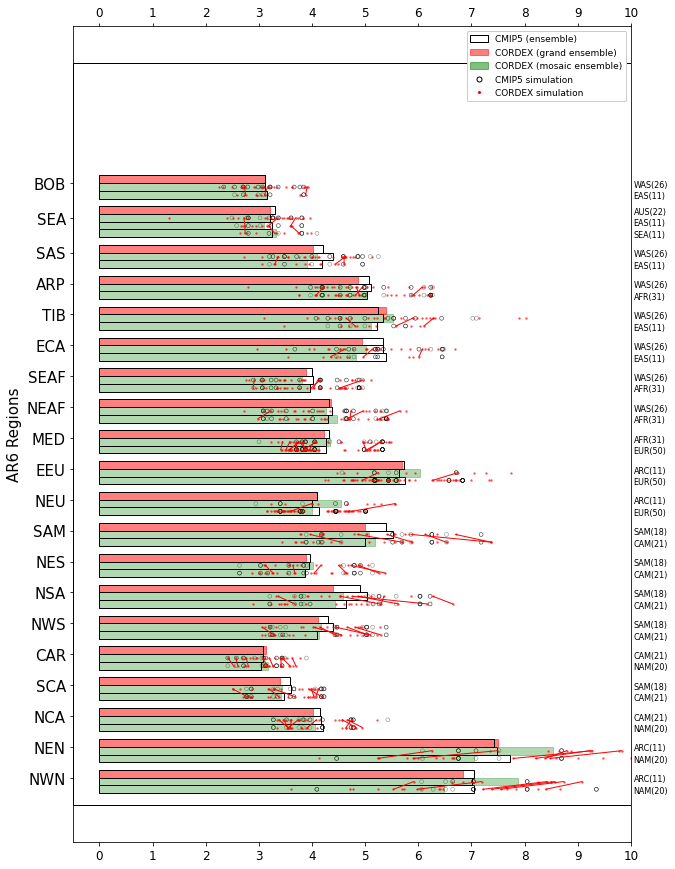

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    fig = plt.figure(figsize = (10, 15))
    ax = fig.add_subplot(111)
    ax.add_patch(Rectangle((-0.5, 0), 10+0.5, 19.2, fill=None, alpha=1))
    y_means = []
    doms_string = []
    posi_y = 0.3
    sep_reg = []

    for n_reg, reg in enumerate(pr_mean_dom_AR6_period_drop.columns):

        doms_COR = tas_mean_dom_AR6_period_drop[reg][tas_mean_dom_AR6_period_drop[reg].notnull()].index
        yvals = tas_mean_dom_AR6_period_drop[reg][tas_mean_dom_AR6_period_drop[reg].notnull()]
        yvals_CMIP5 = tas_mean_dom_AR6_period_drop_CMIP5[reg][tas_mean_dom_AR6_period_drop_CMIP5[reg].notnull()]
        nsim_mosaic = tas_mean_dom_AR6_n_sim_drop[reg].values[~pd.isnull(tas_mean_dom_AR6_n_sim_drop[reg].values)]

        if len(yvals) == 2: 
            for xval_n, xval in enumerate(doms_COR):
                if xval_n == 0: sep_reg.append(posi_y)
                ax.add_patch(Rectangle((0, posi_y), yvals[xval_n], 0.2, color = 'green', alpha=0.3))
                ax.add_patch(Rectangle((0, posi_y), yvals_CMIP5[xval_n], 0.2, fill=None, alpha=1))           

                delta_sim_CORDEX = tas_dic[doms_COR[xval_n] + '_' + reg]['period'].values  
                delta_sim_CMIP5_subensemble = tas_dic_CMIP5_sub[doms_COR[xval_n] + '_' + reg]['period'].values            
                ax.plot(delta_sim_CORDEX, np.ones_like(delta_sim_CORDEX)*(posi_y+0.1), '.r', markersize = 3, alpha = 0.5)
                ax.scatter(delta_sim_CMIP5_subensemble, np.ones_like(delta_sim_CMIP5_subensemble)*(posi_y+0.1), s=15, 
                           facecolors='none', edgecolors='k', linewidths=0.5, alpha = 0.5)

                posi_y = posi_y + 0.2 

            ##join sims
            uno = tas_dic[doms_COR[0] + '_' + reg]['period']
            uno_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in uno.index]
            dos = tas_dic[doms_COR[1] + '_' + reg]['period']
            dos_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in dos.index]
            for n_sim, sim in enumerate(uno_sims):
                if sim in dos_sims:
                    posi_posi = np.where(np.array(dos_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        ax.plot([uno.iloc[n_sim], dos.iloc[pos]], [posi_y-0.3, posi_y-0.1], '-r', linewidth=1, alpha = 1)

            RCM_ensemble = tas_mean_CORDEX_drop_new.loc[reg]
            CMIP5_RCM_ensemble = tas_mean_CMIP5_CORDEX_drop[reg]
            GCM_ensemble = tas_mean_dom_AR6_CMIP5.loc['period'][reg]
            delta_sim_CMIP5 = tas_dic_CMIP5[reg]['period'].values            

            ax.add_patch(Rectangle((0, posi_y), RCM_ensemble.values, 0.2, color = 'red', alpha=0.5))
            ax.add_patch(Rectangle((0, posi_y), CMIP5_RCM_ensemble, 0.2, fill=None, alpha=1))
            y_means.append(posi_y)
            aux_sss = [iicc + '(' + str(nsim_mosaic[nnii]) + ')' for nnii, iicc in enumerate(yvals.index)]    
            doms_string.append('-'.join(aux_sss))

            posi_y = posi_y + 0.4

        elif len(yvals) == 3:

            for xval_n, xval in enumerate(doms_COR):
                if xval_n == 0: sep_reg.append(posi_y)
                ax.add_patch(Rectangle((0, posi_y), yvals[xval_n], 0.2, color = 'green', alpha=0.3))
                ax.add_patch(Rectangle((0, posi_y), yvals_CMIP5[xval_n], 0.2, fill=None, alpha=1)) 
                delta_sim_CORDEX = tas_dic[doms_COR[xval_n] + '_' + reg]['period'].values  
                delta_sim_CMIP5_subensemble = tas_dic_CMIP5_sub[doms_COR[xval_n] + '_' + reg]['period'].values            
                ax.plot(delta_sim_CORDEX, np.ones_like(delta_sim_CORDEX)*(posi_y+0.1), '.r', markersize = 3, alpha = 0.5)
                ax.scatter(delta_sim_CMIP5_subensemble, np.ones_like(delta_sim_CMIP5_subensemble)*(posi_y+0.1), s=15, 
                           facecolors='none', edgecolors='k', linewidths=0.5, alpha = 0.5)

                posi_y = posi_y + 0.2 

            ##join sims
            uno = tas_dic[doms_COR[0] + '_' + reg]['period']
            uno_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in uno.index]
            dos = tas_dic[doms_COR[1] + '_' + reg]['period']
            dos_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in dos.index]
            tres = tas_dic[doms_COR[2] + '_' + reg]['period']
            tres_sims = ['_'.join(sim.split('/')[-1].split('_')[:]) for sim in tres.index]
            for n_sim, sim in enumerate(uno_sims):
                if sim in dos_sims:
                    posi_posi = np.where(np.array(dos_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        ax.plot([uno.iloc[n_sim], dos.iloc[pos]], [posi_y-0.5, posi_y-0.3], '-r', linewidth=1, alpha = 1)
            for n_sim, sim in enumerate(dos_sims):
                if sim in tres_sims:
                    posi_posi = np.where(np.array(tres_sims) == np.array(sim))[0]
                    for pos in posi_posi:
                        ax.plot([dos.iloc[n_sim], tres.iloc[pos]], [posi_y-0.3, posi_y -0.1], '-r', linewidth=1, alpha = 1)

            RCM_ensemble = tas_mean_CORDEX_drop_new.loc[reg]
            CMIP5_RCM_ensemble = tas_mean_CMIP5_CORDEX_drop[reg]
            GCM_ensemble = tas_mean_dom_AR6_CMIP5.loc['period'][reg]
            delta_sim_CMIP5 = tas_dic_CMIP5[reg]['period'].values            

            ax.add_patch(Rectangle((0, posi_y), RCM_ensemble.values, 0.2, color = 'red', alpha=0.5))
            ax.add_patch(Rectangle((0, posi_y), CMIP5_RCM_ensemble, 0.2, fill=None, alpha=1))        
            y_means.append(posi_y-0.1)
            aux_sss = [iicc + '(' + str(nsim_mosaic[nnii]) + ')' for nnii, iicc in enumerate(yvals.index)]    
            doms_string.append('-'.join(aux_sss))

            posi_y = posi_y + 0.4 

        else:
            sys.exit()

    ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                         bottom=True, top=True, left=True, right=False)
    ax.set_yticks(y_means)
    ax.set_yticklabels(pr_mean_dom_AR6_period_drop.columns, fontsize = 15, rotation='horizontal')
    ax.set_ylabel('AR6 Regions', fontsize = 15)
    ax.set_xlim([-0.5, 10])
    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_xticklabels(np.arange(0, 11, 1), fontsize = 12, rotation='horizontal')
    ax.legend(handles=legend_elements, loc='upper right', fontsize = 9, facecolor = 'w', framealpha=1)

    for ndnd, dom_s in enumerate(doms_string):
        n_rr = 0
        for nrr, dom_r in enumerate(dom_s.split('-')):
            ax.annotate(dom_r, xy=(10+0.05,sep_reg[ndnd]+n_rr), xytext=(10+0.05,sep_reg[ndnd]+n_rr), xycoords='data', annotation_clip=False, fontsize = 8)
            n_rr = n_rr + 0.3

### References

Boé, J., Somot, S., Corre, L., & Nabat, P. (2020). Large discrepancies in summer climate change over Europe as projected by global and regional climate models: causes and consequences. Climate Dynamics, 54(5), 2981-3002.

Iturbide, Maialen, Fernández, Jesús, Gutiérrez, José Manuel, Bedia, Joaquín, Cimadevilla, Ezequiel, Díez-Sierra, Javier, Manzanas, Rodrigo, Casanueva, Ana, Baño-Medina, Jorge, Milovac, Josipa, Herrera, Sixto, Cofiño, Antonio S., San Martín, Daniel, García-Díez, Markel, Hauser, Mathias, Huard, David, & Yelekci, Özge. (2021). Repository supporting the implementation of FAIR principles in the IPCC-WGI Atlas (v2.0-final). Zenodo. https://doi.org/10.5281/zenodo.5171760